In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
epoch_data_path = parentDir / "data/processed/ninapro_ex1_win200_ms_step50_ms.npz"
save_figs = True

In [104]:
data = np.load(epoch_data_path)

X = data['X']
y = data['y']
subject_ids = data['subject_ids']
rep_ids = data['rep_ids']
t0 = data['t0']
coverage = data['coverage']
Fs = data['Fs'].item()
n_channels = data['n_channels'].item()
L = data['L']
Ld = data['Ld']
T_ms = data['T_ms']
S_ms = data['S_ms']
gesture_ids_all = data['gesture_ids_all']
exercise_number = data['exercise_number']
include_rest = data['include_rest']
majority_threshold = data['majority_threshold']

In [105]:
print(f"Data shape: X={X.shape}, y={y.shape}, rep_ids={rep_ids.shape}, subject_ids={subject_ids.shape}")
print(f"Unique gestures: {np.unique(y)}")
print(f"Unique subjects: {np.unique(subject_ids)}")
print(f"Unique repetitions: {np.unique(rep_ids)}")

Data shape: X=(690099, 12, 400), y=(690099,), rep_ids=(690099,), subject_ids=(690099,)
Unique gestures: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Unique subjects: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Unique repetitions: [0 1 2 3 4 5 6]


### Decicde goals
- goal: cross-subject generalization: train on some subjects, test on held-out subjects
- task: 17-class gesture classification (labels 1...17)

In [106]:
from utils.ml_helpers import set_seeds, get_device
set_seeds(42)
device = get_device()

In [107]:
from utils.postprocessing import exclude_rest_class, split_data_by_subject, encode_labels_zero_based
X, y, subject_ids, rep_ids = exclude_rest_class(X, y, subject_ids, rep_ids)
y = encode_labels_zero_based(y)


print(f"After excluding rest class: X={X.shape}, y={y.shape}")
print(f"Unique gestures after excluding rest and zero indexing: {np.unique(y)}")

train_indices, test_indices, val_indices = split_data_by_subject(subject_ids)

After excluding rest class: X=(361730, 12, 400), y=(361730,)
Unique gestures after excluding rest and zero indexing: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Train subjects: [20 17 16 27  5 13 38 28 40  7 26 10 14 32 35  9 18 25  1 34  6 12  2 30
 22  3 31 37]
Test subjects: [ 4 36 24 33 11 23]
Validation subjects: [19 21  8 15 29 39]


In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [109]:
from utils.ml_helpers import EMGDataset, Standardize1D

X_train = X[train_indices]
channel_means_tensor = torch.tensor(X_train.mean(axis=(0,2)), dtype=torch.float32)[:, None]
channel_stds_tensor = torch.tensor(X_train.std(axis=(0,2)).clip(min=1e-8), dtype=torch.float32)[:, None]

normalize = Standardize1D(channel_means_tensor, channel_stds_tensor)
train_ds = EMGDataset(X_train, y[train_indices], transform=normalize)
val_ds   = EMGDataset(X[val_indices],  y[val_indices], transform=normalize)
test_ds  = EMGDataset(X[test_indices], y[test_indices], transform=normalize)

In [110]:
from utils.ml_helpers import CNN_model, accuracy, train_one_epoch, validate_one_epoch, get_lrs

In [111]:
# Initialize all hyperparameters in one place
batch_size = 128
num_epochs = 100
learning_rate = 0.001
kernel_size = 31
conv1out = 128
p_dropout = 0.2
conv2out = 128
kernel_size2 = 15
p_dropout2 = 0.1
pool1_ks = None


num_classes = len(np.unique(y))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [112]:
model = CNN_model(inChannels=n_channels, numClasses=num_classes, kernel_size=kernel_size, conv1out=conv1out, p_dropout=p_dropout,
                  kernel_size2=kernel_size2, conv2out=conv2out, p_dropout2=p_dropout2, pool1_ks=pool1_ks)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, min_lr=1e-5)
print(model)

CNN_model(
  (conv1): Conv1d(12, 128, kernel_size=(31,), stride=(1,), padding=(15,))
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (pool1): Identity()
  (conv2): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,))
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv3): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,))
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=17, bias=True)
)


In [113]:
import time
import json

# describe this run
hparams = dict(
    model="CNN_model",
    in_ch=n_channels, num_classes=num_classes,
    conv_out=conv1out, kernel_size=kernel_size, p_drop=p_dropout,
    lr=learning_rate, batch_size=batch_size, epochs=num_epochs, seed=42,
    conv2_out=conv2out, kernel_size2=kernel_size2, p_dropout2=p_dropout2,
    notes="baseline two-layer cnn"
)

# unique run id
run_id = time.strftime("%Y%m%d-%H%M%S")
run_name = f"{hparams['model']}_k{hparams['kernel_size']}_f{hparams['conv_out']}_lr{hparams['lr']}_bs{hparams['batch_size']}_{run_id}"
run_dir = parentDir/"models"/run_name
run_dir.mkdir(parents=True, exist_ok=True)

# save config
with open(run_dir/"config.json","w") as f:
    json.dump(hparams, f, indent=2)

In [114]:
import torch, pprint

path_best = run_dir / "best.pt"   # or give a full Path/str
ckpt = torch.load(path_best, map_location="cpu")   # safe to load on CPU

FileNotFoundError: [Errno 2] No such file or directory: '/Users/suma/Documents/emg-gesture-classification-ninapro/models/CNN_model_k31_f128_lr0.001_bs128_20251112-121453/best.pt'

In [115]:

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [116]:
from pathlib import Path
best_ckpt = run_dir/"best.pt"
last_ckpt = run_dir/"last.pt"


history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

best_val_acc = 0.0
bad_epochs = 0
patience = 25
ckpt_path = "smallcnn1d_best.pt"


for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    va_loss, va_acc = validate_one_epoch(model, val_loader, loss_fn, device)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    # LR scheduler step
    scheduler.step(va_acc)
    current_lrs = get_lrs(optimizer)[0]
    history["lr"].append(current_lrs)

    print(f"Epoch {epoch+1:03d} | "
        f"train: {tr_loss:.4f}/{tr_acc:.3f} | "
        f"val: {va_loss:.4f}/{va_acc:.3f} | "
        f"lr: {current_lrs:.2e}")

    # save 'last' every epoch
    torch.save({
        "epoch": epoch+1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "history": history,
        "hparams": {"lr": learning_rate, "batch_size": batch_size}
    }, last_ckpt)

    # save 'best' when val_acc improves (and reset early-stop counter)
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        bad_epochs = 0
        torch.save(torch.load(last_ckpt), best_ckpt)
    else:
        bad_epochs += 1
        # early stopping
        if bad_epochs >= patience:
            print(f"Early stopping (no val acc improvement for {patience} epochs).")
            break

# Load best before test/plots
best = torch.load(best_ckpt, map_location=device)
model.load_state_dict(best["model_state"])


Epoch 001 | train: 2.8462/0.070 | val: 2.8067/0.071 | lr: 1.00e-03
Epoch 002 | train: 2.7824/0.109 | val: 2.7655/0.126 | lr: 1.00e-03
Epoch 003 | train: 2.6108/0.164 | val: 2.7171/0.140 | lr: 1.00e-03
Epoch 004 | train: 2.5126/0.234 | val: 2.6712/0.170 | lr: 1.00e-03
Epoch 005 | train: 2.5533/0.211 | val: 2.6311/0.176 | lr: 1.00e-03
Epoch 006 | train: 2.6350/0.172 | val: 2.5816/0.205 | lr: 1.00e-03
Epoch 007 | train: 2.4098/0.281 | val: 2.5453/0.226 | lr: 1.00e-03
Epoch 008 | train: 2.3796/0.273 | val: 2.5133/0.238 | lr: 1.00e-03
Epoch 009 | train: 2.4089/0.250 | val: 2.4824/0.245 | lr: 1.00e-03
Epoch 010 | train: 2.4544/0.188 | val: 2.4634/0.240 | lr: 1.00e-03
Epoch 011 | train: 2.3802/0.273 | val: 2.4506/0.242 | lr: 1.00e-03
Epoch 012 | train: 2.1480/0.352 | val: 2.4376/0.251 | lr: 1.00e-03
Epoch 013 | train: 2.3286/0.289 | val: 2.4385/0.252 | lr: 1.00e-03
Epoch 014 | train: 2.3821/0.273 | val: 2.4337/0.252 | lr: 1.00e-03
Epoch 015 | train: 2.3274/0.258 | val: 2.4324/0.249 | lr: 1.00

<All keys matched successfully>

In [117]:
import pandas as pd
epochs = range(1, len(history["train_loss"])+1)
pd.DataFrame({
    "epoch": epochs,
    "train_loss": history["train_loss"],
    "val_loss": history["val_loss"],
    "train_acc": history["train_acc"],
    "val_acc": history["val_acc"],
    "lr": history["lr"],
}).to_csv(f"{run_dir}/training_history.csv", index=False)

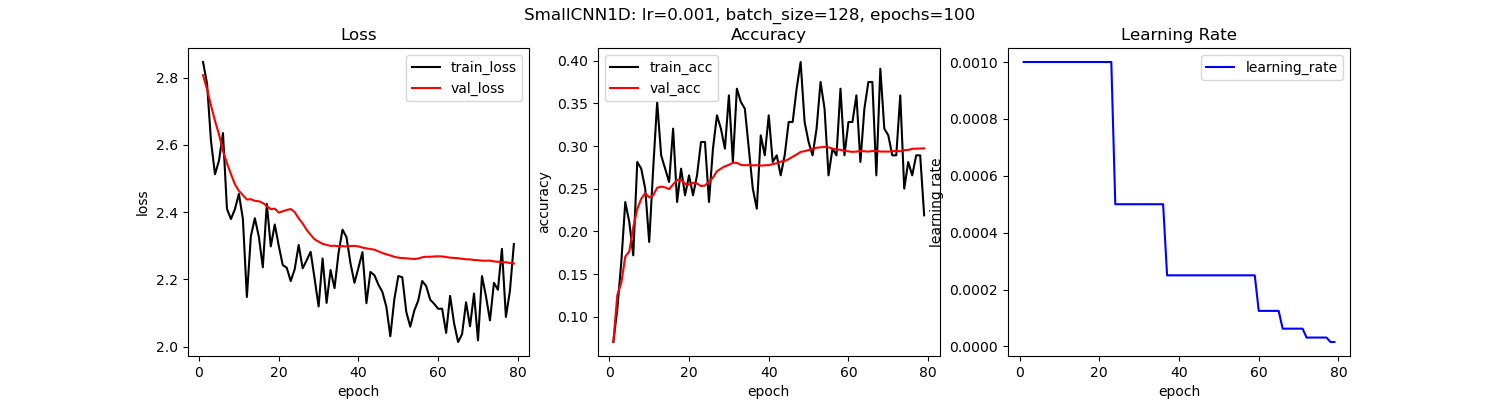

In [118]:
%matplotlib widget
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"])+1)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(epochs, history["train_loss"], label="train_loss", color='black')
axs[0].plot(epochs, history["val_loss"],   label="val_loss", color='red')
axs[0].set_xlabel("epoch"); axs[0].set_ylabel("loss"); axs[0].legend(); axs[0].set_title("Loss")

axs[1].plot(epochs, history["train_acc"], label="train_acc", color='black')
axs[1].plot(epochs, history["val_acc"],   label="val_acc", color='red')
axs[1].set_xlabel("epoch"); axs[1].set_ylabel("accuracy"); axs[1].legend(); axs[1].set_title("Accuracy")

axs[2].plot(epochs, history["lr"], label="learning_rate", color='blue')
axs[2].set_xlabel("epoch"); axs[2].set_ylabel("learning rate")
axs[2].legend(); axs[2].set_title("Learning Rate")
# Set title with hyperparameters
plt.suptitle(f"SmallCNN1D: lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")
if save_figs:
    plt.savefig(f"{run_dir}/cnn_training_curve_{learning_rate}_{batch_size}_{num_epochs}.png")
    # Save history
    np.savez(f"{run_dir}/cnn_training_history_{learning_rate}_{batch_size}_{num_epochs}.npz", **history)
plt.show()


In [119]:
import torch
import numpy as np

@torch.no_grad()
def predict_loader(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)                    # (B, C) logits
        probs  = torch.softmax(logits, dim=1)     # (B, C) probabilities
        preds  = probs.argmax(1)              # (B,)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())
        y_prob.append(probs.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    y_prob = torch.cat(y_prob).numpy()
    return y_true, y_pred, y_prob

y_test, yhat_test, p_test = predict_loader(model, test_loader, device)
print("Test size:", y_test.shape, " | probs shape:", p_test.shape)


Test size: (60086,)  | probs shape: (60086, 17)


In [120]:
print(f"Unique classes in y_test: {np.unique(y_test)[:]}")
print(f"Unique classes in yhat_test: {np.unique(yhat_test)[:]}")

Unique classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Unique classes in yhat_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [121]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, yhat_test)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.289


In [124]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# num_classes = len(np.unique(y))
class_names = range(num_classes)


cm = confusion_matrix(y_test, yhat_test, labels=range(num_classes))
report = classification_report(y_test, yhat_test, labels=class_names,target_names=class_names, output_dict=True, zero_division=0)

# Per-class counts
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (tp + fp + fn)
per_class_acc = np.divide(tp, cm.sum(axis=1, keepdims=False), out=np.zeros_like(tp, dtype=float), where=cm.sum(axis=1)!=0)

metrics_df = pd.DataFrame({
    "class": class_names,
    "support": cm.sum(axis=1),
    "TP": tp, "FP": fp, "FN": fn, "TN": tn,
    "accuracy": per_class_acc,
    "precision": [report[n]["precision"] for n in class_names],
    "recall":    [report[n]["recall"]    for n in class_names],
    "f1":        [report[n]["f1-score"]  for n in class_names],
}).sort_values("accuracy", ascending=False)

display(metrics_df.head(17))
print("\nMacro F1:", report["macro avg"]["f1-score"], " | Weighted F1:", report["weighted avg"]["f1-score"])


,class,support,TP,FP,FN,TN,accuracy,precision,recall,f1
0,0,4550,3453,6476,1097,49060,0.758901,0.347769,0.758901,0.476967
8,8,3580,2629,5021,951,51485,0.734358,0.343660,0.734358,0.468210
6,6,4375,2142,6090,2233,49621,0.489600,0.260204,0.489600,0.339811
16,16,3011,1073,1306,1938,55769,0.356360,0.451030,0.356360,0.398145
15,15,3320,1169,3415,2151,53351,0.352108,0.255017,0.352108,0.295800
14,14,3496,1228,4298,2268,52292,0.351259,0.222222,0.351259,0.272223
12,12,2725,906,1024,1819,56337,0.332477,0.469430,0.332477,0.389259
13,13,2575,792,1080,1783,56431,0.307573,0.423077,0.307573,0.356195
2,2,3291,856,2897,2435,53898,0.260103,0.228084,0.260103,0.243044
5,5,3322,752,387,2570,56377,0.226370,0.660228,0.226370,0.337144



Macro F1: 0.2539358268898617  | Weighted F1: 0.25238650441778987


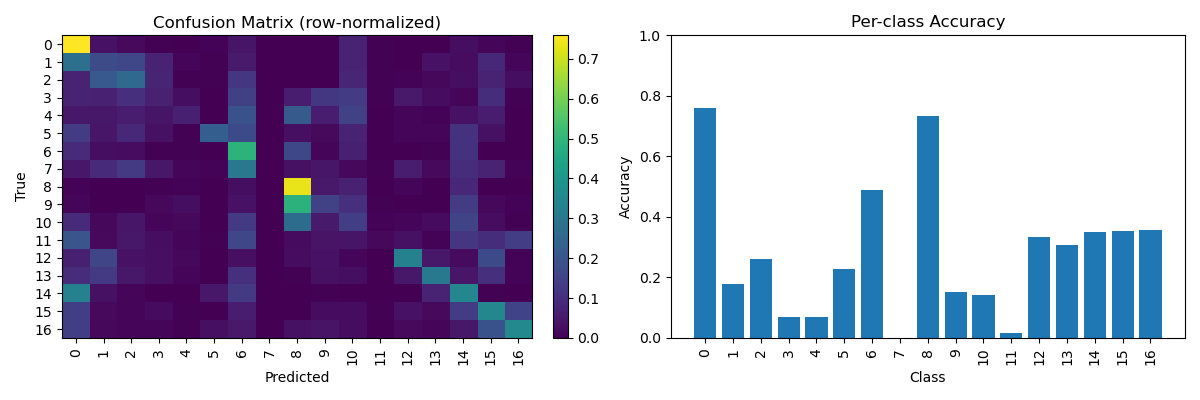

In [125]:
import matplotlib.pyplot as plt

# Normalized CM by true class (rows sum to 1)
row_sum = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sum, out=np.zeros_like(cm, dtype=float), where=row_sum!=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Confusion matrix
im = axs[0].imshow(cm_norm, aspect='auto')
axs[0].set_title("Confusion Matrix (row-normalized)")
axs[0].set_xlabel("Predicted"); axs[0].set_ylabel("True")
axs[0].set_xticks(range(num_classes)); axs[0].set_yticks(range(num_classes))
axs[0].set_xticklabels(class_names, rotation=90); axs[0].set_yticklabels(class_names)
fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)

# Per-class accuracy
axs[1].bar(range(num_classes), per_class_acc)
axs[1].set_title("Per-class Accuracy")
axs[1].set_xlabel("Class"); axs[1].set_ylabel("Accuracy")
axs[1].set_xticks(range(num_classes)); axs[1].set_xticklabels(class_names, rotation=90)
axs[1].set_ylim(0, 1.0)
plt.tight_layout(); plt.show()


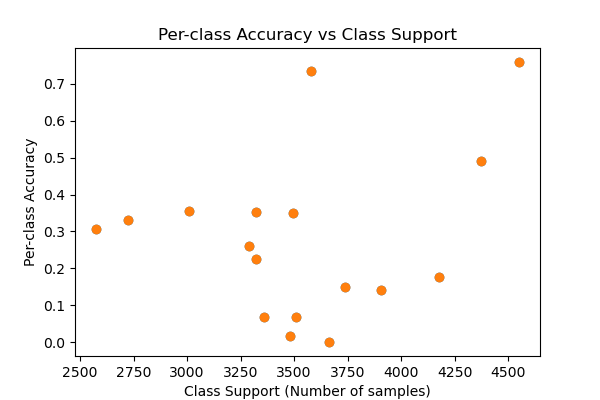

In [140]:
# Check if class weights affect per-class accuracy
# Plot a scatter plot of per-class accuracy vs class support
plt.figure(figsize=(6,4))
plt.scatter(metrics_df["support"], metrics_df["accuracy"])
plt.scatter(cm.sum(axis=1, keepdims=True), per_class_acc)
plt.xlabel("Class Support (Number of samples)")
plt.ylabel("Per-class Accuracy")
plt.title("Per-class Accuracy vs Class Support")
plt.show()

In [48]:
pd.DataFrame({
    "y_true": y_test,
    "y_pred": yhat_test,
    **{f"p_{i}": p_test[:, i] for i in range(num_classes)}
}).to_csv(run_dir/"test_predictions.csv", index=False)

metrics_df.to_csv(run_dir/"per_class_metrics.csv", index=False)


IndexError: index 17 is out of bounds for axis 1 with size 17